# Download and run an e-model 

If the emodel data is already downloaded, you can proceed directly to the 'Simulating the Emodel' section

## Downloading the Emodel

In [1]:
from kgforge.core import KnowledgeGraphForge
import getpass
from bluepyemodel.access_point.nexus import NexusAccessPoint
import os
import shutil
from pathlib import Path


In [2]:
def connect_forge(bucket, endpoint, access_token, forge_path=None):
    """Creation of a forge session"""

    forge = KnowledgeGraphForge(
        forge_path, bucket=bucket, endpoint=endpoint, token=access_token
    )
    return forge

Specify the Nexus ID for the emodel you wish to simulate. Ensure to set the correct organisation/project. Below is a list of Nexus ID of some of the detailed canonical emodel

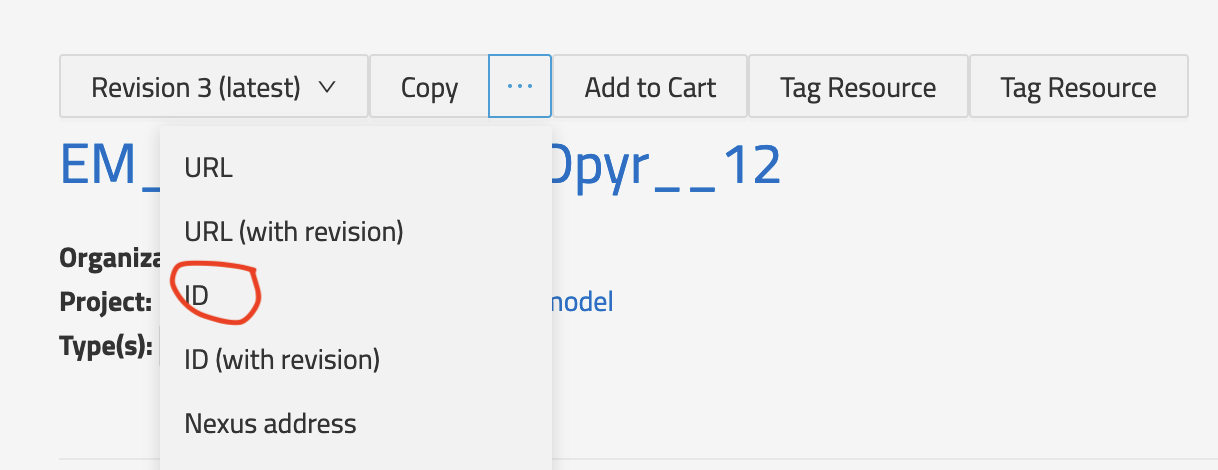

In [3]:
from IPython.display import display, Image
display(Image(filename="img_nexus_id.png"))

In [4]:
emodel_id="" # paste the id here

ORG = "" # paste the organization here
PROJECT = "" # paste the project here

# Advanced settings
endpoint = "https://bbp.epfl.ch/nexus/v1"
forge_path = (
    "https://raw.githubusercontent.com/BlueBrain/nexus-forge/"
    + "master/examples/notebooks/use-cases/prod-forge-nexus.yml"
)

Get the EModel (EM) resource from Nexus and download its morphology, mechanisms, hoc and the final parameters

To obtain your Nexus access token, please visit https://bbp.epfl.ch/nexus/web/:

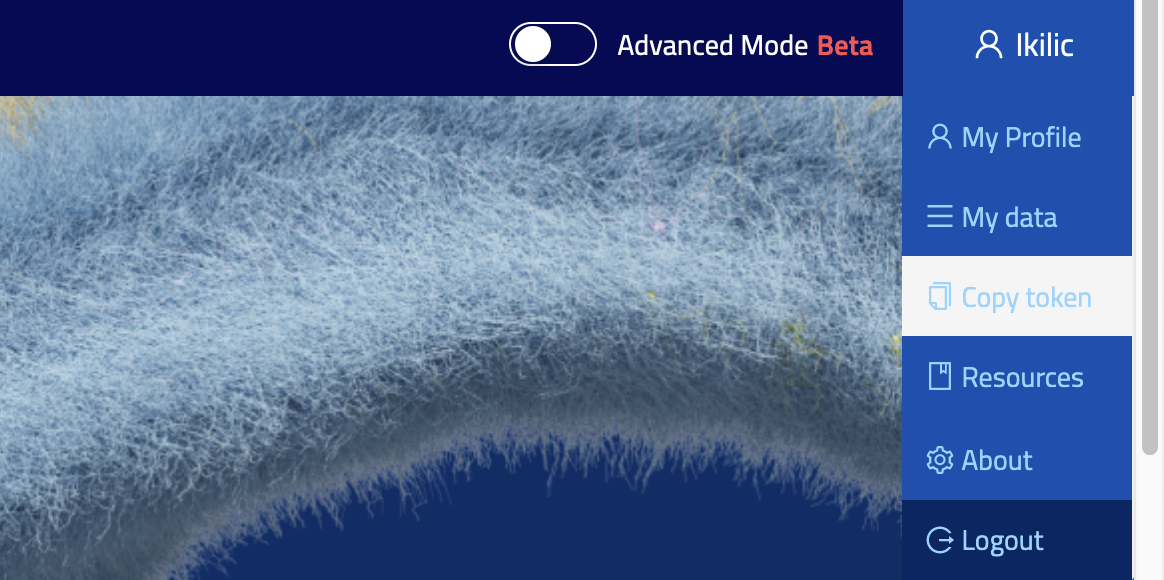

In [5]:
from IPython.display import display, Image
display(Image(filename="img_nexus_token.png"))

In [ ]:
access_token = getpass.getpass()
forge = connect_forge(f"{ORG}/{PROJECT}", endpoint, access_token, forge_path=forge_path)
r = forge.retrieve(emodel_id)

if r is None:
    raise ValueError(f"Resource with id {emodel_id} not found.")
emodel = r.__dict__.get('eModel', r.__dict__.get('emodel'))
etype = r.__dict__.get('eType', r.__dict__.get('etype', None))
ttype = r.__dict__.get('tType', r.__dict__.get('ttype', None))
mtype = r.__dict__.get('mType', r.__dict__.get('mtype', None))
iteration_tag = r.__dict__.get("iteration", None)
seed = r.__dict__.get("seed", None)

if r.subject.species.label == "Rattus norvegicus":
    species = "rat"
elif r.subject.species.label == "Mus musculus":
    species = "mouse"
elif r.subject.species.label == "Homo sapiens":
    species = "human"
else:
    raise ValueError(f"Species {r.subject.species.label} not supported.")

brain_region = r.brainLocation.brainRegion.label

metadata = {
    "emodel": emodel,
    "etype": etype,
    "mtype": mtype,
    "ttype": ttype,
    "species": species,
    "iteration_tag": iteration_tag,
    "brain_region": brain_region,
}

# Download data from Nexus
nap = NexusAccessPoint(
    **metadata,
    project=PROJECT,
    organisation=ORG,
    endpoint=endpoint,
    access_token=access_token,
    forge_path=forge_path,
    sleep_time=7,
)

print("Downloading data...")
model_configuration = nap.get_model_configuration()
nap.get_hoc()
nap.get_emodel()

## Simulating the Emodel 

In [7]:
from matplotlib import pyplot as plt
import glob
import json
import os
import shutil
from pathlib import Path

Copies the necessary mechanisms into the working directory

In [8]:
def load_mechanism(directory_path):
    #Copy the correct mechanism in the working directory

    if os.path.exists("x86_64") and os.path.isdir("x86_64"):
        shutil.rmtree("x86_64")
    source_folder = f"{directory_path}/x86_64/"
    destination_folder = "./x86_64/"
    shutil.copytree(source_folder, destination_folder)

folder_id = nap.get_emodel().emodel_metadata.as_string()
directory_path = f"./nexus_temp/{folder_id}"
load_mechanism(directory_path)

### Loading the data for the simulation

Read the EModel resource which contains the final features of the emodel to get the holding and threshold current

In [9]:
def getHoldingThreshCurrent(directory_path):
    pattern = os.path.join(directory_path, 'EM_*' + 'json')
    final = glob.glob(pattern)
    if final:
        file_name = final[0]
        with open(file_name, 'r') as file:
            data = json.load(file)
    else:
        raise FileNotFoundError(f"No EModel resource found in {directory_path}.")

    holding_current = 0
    threshold_current = 0

    for feature in data['features']:
        if 'bpo_holding_current' in feature['name']:
            holding_current = feature['value']
            print(feature)
        elif 'bpo_threshold_current' in feature['name']:
            threshold_current = feature['value']
            print(feature)

    return (holding_current, threshold_current)

Load the hoc and morphology

In [10]:
hoc_file = Path(directory_path) / "model.hoc"
morph_file = nap.download_morphology(model_configuration.morphology.name, model_configuration.morphology.format, model_configuration.morphology.id)
holding_current, threshold_current = getHoldingThreshCurrent(directory_path)

In [ ]:
from bluecellulab import Cell, Simulation
from bluecellulab.stimulus.circuit_stimulus_definitions import OrnsteinUhlenbeck, ShotNoise
from bluecellulab.simulation.neuron_globals import NeuronGlobals
from bluecellulab.circuit.circuit_access import EmodelProperties

NeuronGlobals.get_instance().temperature = 34.0
NeuronGlobals.get_instance().v_init = -70

emodel_properties = EmodelProperties(threshold_current=threshold_current,
                                    holding_current=holding_current)

### Step Stimulus

In [ ]:
# Define stimulus parameters
start_time = 15.0  # Start time of the stimulus
stop_time = 25.0   # Stop time of the stimulus
level = 1.0       # Current level of the stimulus

cell = Cell(hoc_file, morph_file, template_format="v6", emodel_properties=emodel_properties)
icneurodamusobj = cell.add_step(start_time=start_time, stop_time=stop_time, level=level)

In [ ]:
import neuron
iclamp_current = neuron.h.Vector()
iclamp_current.record(icneurodamusobj.ic._ref_i)

In [14]:
# Run the simulation
max_time = 100
sim = Simulation()
sim.add_cell(cell)
sim.run(max_time, cvode=False)
time, voltage = cell.get_time(), cell.get_soma_voltage()

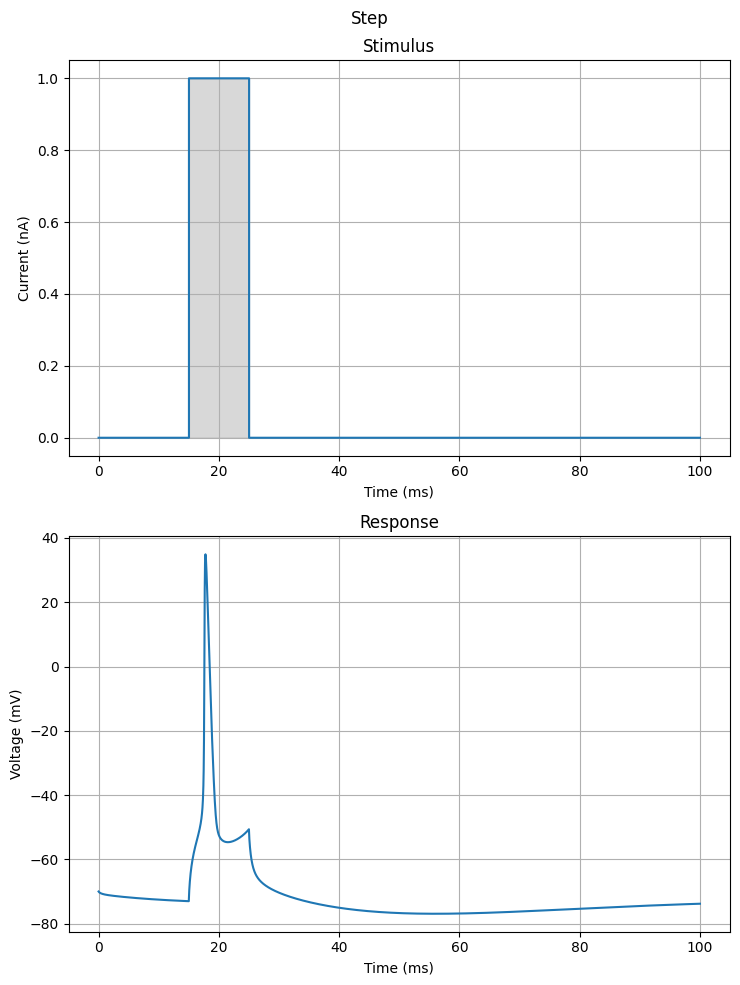

In [15]:
# Plot the simulation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7.5, 10))

ax1.plot(time, iclamp_current, drawstyle='steps-post')
ax1.set_title("Stimulus")
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Current (nA)")
ax1.fill_between(time, 0, list(iclamp_current), step="post", color='gray', alpha=0.3)
ax1.grid(True)

ax2.plot(time, voltage)
ax2.set_title("Response")
ax2.set_xlabel("Time (ms)")
ax2.set_ylabel("Voltage (mV)")
ax2.grid(True)

plt.suptitle("Step")
plt.tight_layout()
plt.show()

### Ramp stimulus

In [ ]:
# Define ramp stimulus parameters
start_time = 50.0  # Start time of the ramp
stop_time = 125.0   # Stop time of the ramp
start_level = 0.0  # Start level of the ramp
stop_level = 2.0   # Stop level of the ramp

cell = Cell(hoc_file, morph_file, template_format="v6", emodel_properties=emodel_properties)
ramp_obj = cell.add_ramp(start_time=start_time, stop_time=stop_time, start_level=start_level, stop_level=stop_level)

ramp_current = neuron.h.Vector()
ramp_current.record(ramp_obj.ic._ref_i)

# To add the holding current
# from bluecellulab.cell.injector import Hyperpolarizing
# hyperpolarizing = Hyperpolarizing("single-cell", delay=0, duration=params['tstop'])
# cell.add_replay_hypamp(hyperpolarizing)

In [17]:
# Run the simulation
max_time = 200
sim = Simulation()
sim.add_cell(cell)
sim.run(max_time, cvode=False)
time, voltage = cell.get_time(), cell.get_soma_voltage()

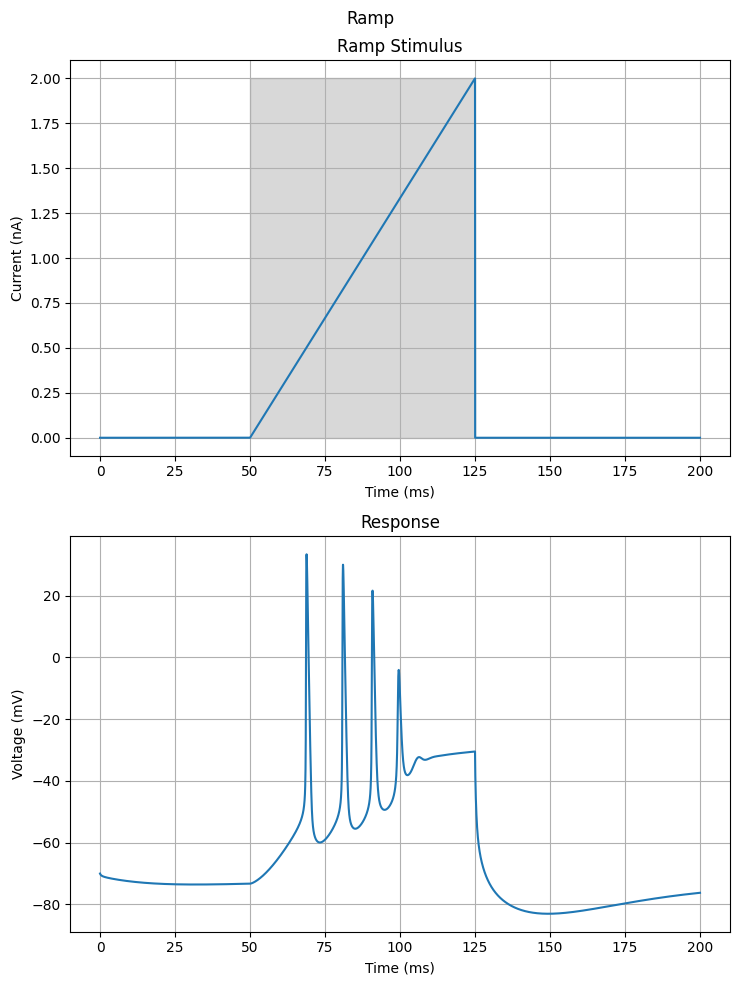

In [18]:
# Plot the simulation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7.5, 10))

ax1.plot(time, ramp_current)
ax1.set_title("Ramp Stimulus")
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Current (nA)")
ax1.fill_between([start_time, stop_time], start_level, stop_level, color='gray', alpha=0.3)
ax1.grid(True)

ax2.plot(time, voltage)
ax2.set_title("Response")
ax2.set_xlabel("Time (ms)")
ax2.set_ylabel("Voltage (mV)")
ax2.grid(True)

plt.suptitle("Ramp")
plt.tight_layout()
plt.show()

### Shot noise stimulus

In [19]:
shotnoise_stimulus = ShotNoise(
    target="single-cell", delay=25, duration=20,
    rise_time=0.4, decay_time=4, rate=2E3, amp_mean=40E-3, amp_var=16E-4,
    seed=3899663
)

In [ ]:
cell = Cell(hoc_file, morph_file, template_format="v6", emodel_properties=emodel_properties)
time_vec, stim_vec = cell.add_replay_shotnoise(
    cell.soma, 0.5,
    shotnoise_stimulus,
    shotnoise_stim_count=3)
time_vec = time_vec.to_python()
stim_vec = stim_vec.to_python()

In [21]:
# Run the simulation
max_time = 60
sim = Simulation()
sim.add_cell(cell)
sim.run(max_time, cvode=False)
time, voltage = cell.get_time(), cell.get_soma_voltage()

In [22]:
# add 0 to the beginning of the stim vector
new_stim_vec = [0] + stim_vec + [0]

In [23]:
new_time_vec = [0]+time_vec+[max_time]

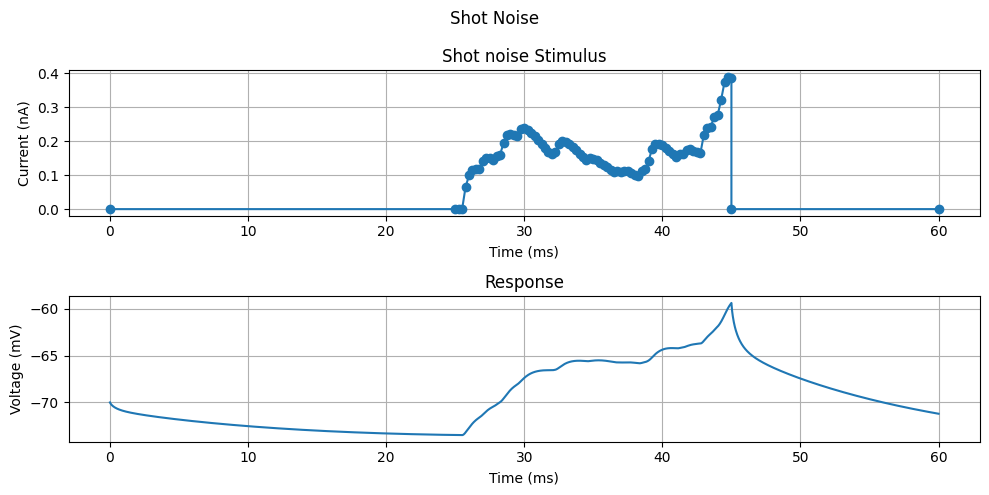

In [24]:
# Plot the simulation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))

ax1.plot(new_time_vec, new_stim_vec, '-o')
# ax1.plot(time_vec, stim_vec, '-o')
ax1.set_title("Shot noise Stimulus")
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Current (nA)")
ax1.grid(True)

ax2.plot(time, voltage)
ax2.set_title("Response")
ax2.set_xlabel("Time (ms)")
ax2.set_ylabel("Voltage (mV)")
ax2.grid(True)

plt.suptitle("Shot Noise")
plt.tight_layout()
plt.show()